In [63]:
from micromort.datasets.risk_dataset import RiskDataset
import pandas as pd
import csv
import nltk
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from collections import defaultdict

### Get the dataset

In [7]:
risk_train_dataset = RiskDataset()
risk_test_dataset = RiskDataset(train=False)
# X_train = []
# Y_train = []
# X_test = []
# Y_test = []
# for row in risk_train_dataset:
#     X_train.append(row[0])
#     Y_train.append(row[1])
# for row in risk_test_dataset:
#     X_test.append(row[0])
#     Y_test.append(row[1])
train, test = sklearn.model_selection.train_test_split(pd.DataFrame.from_records(risk_train_dataset.annotated_data))
test.shape, train.shape

Loading the human annotated data from pickle file
Loading the tokens from the token files
Loading words_to_idx from pickle file
The size of the vocab 3004
Train proportion: 0.8, Number of train 1122, Number of test 280
Loading the human annotated data from pickle file
Loading the tokens from the token files
Loading words_to_idx from pickle file
The size of the vocab 3004
Train proportion: 0.8, Number of train 1122, Number of test 280


((351, 5), (1051, 5))

In [8]:
train.head()

,article_headline,article_id,article_text,risk_category,sentiment_category
488,UOB launches scheme to help millennials build ...,1015,United Overseas Bank (UOB) has launched a sche...,[97],1
109,Health staff at Nanjing Youth Olympic games on...,247,CHINA - Citing feasible plans and disease cont...,[91],-1
1057,Trump would welcome challenge from Oprah for p...,2327,ABOARD AIR FORCE ONE (REUTERS) - US President ...,[98],0
381,E-cigarette row could block new EU tobacco rul...,777,BRUSSELS - Disagreement over how to regulate t...,"[91, 98]",-1
1347,Must-have gadgets and apps for your next trip,2996,Digital Life turns travel planner to bring you...,[99],0


## Data pre processing

In [9]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Error loading stopwords: <urlopen error [Errno 111]
[nltk_data]     Connection refused>


In [10]:
X_train, y_train = train['article_text'].values, train['risk_category'].values
X_val, y_val = test['article_text'].values, test['risk_category'].values

In [11]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1051,), (1051,), (351,), (351,))

In [12]:
def text_prepare(texts):
    processed_texts = []
    for i, text in enumerate(texts):
        _text = text.lower()
        _text = re.compile('[/(){}\[\]\|@,;]').sub(r' ', _text)
        _text = re.compile('[^0-9a-z #+_]').sub(r'', _text)
        _text = ' '.join([word for word in _text.split() if word not in set(stopwords.words('english'))])
        processed_texts.append(_text)
    return processed_texts

def splitAndProcess(X, func, num_partitions, num_cores=4):
    df_split = np.array_split(np.array(X), num_partitions)
    pool = Pool(num_cores)
    X = np.concatenate(pool.map(func, df_split))
    pool.close()
    pool.join()
    return X

In [13]:
X_train = splitAndProcess(X_train, text_prepare, 8, 8)
X_val = splitAndProcess(X_val, text_prepare, 8, 8)

In [14]:
tfidf_vectorizer = TfidfVectorizer(min_df = .001, ngram_range=(1,5), token_pattern='(\S+)').fit(X_train)

def tfidf_features(X):
    return tfidf_vectorizer.transform(X)

In [16]:
X_train_tfidf = tfidf_features(X_train)
X_val_tfidf = tfidf_features(X_val)

In [17]:
print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)

number of features:  (1051, 42042) (351, 42042)


### Visualize 

In [22]:
train_tags_counts = {}
test_tags_counts = {}
class_mapping = {
91: 'health', 92: 'safety_security', 93 : 'environment',
                      94 : 'social_relations', 95 : 'meaning_in_life', 96 : 'achievement',
                      97 : 'economics', 98 : 'politics', 99 : 'not_applicable', 0 : 'skip' }
for y in y_train:
    for tag in y:
        if class_mapping[tag] in train_tags_counts:
            train_tags_counts[class_mapping[tag]] = train_tags_counts[class_mapping[tag]] + 1
        else:
            train_tags_counts[class_mapping[tag]] = 1

for y in y_val:
    for tag in y:
        if class_mapping[tag] in test_tags_counts:
            test_tags_counts[class_mapping[tag]] = test_tags_counts[class_mapping[tag]] + 1
        else:
            test_tags_counts[class_mapping[tag]] = 1
tfidf_vocab = tfidf_vectorizer.vocabulary_

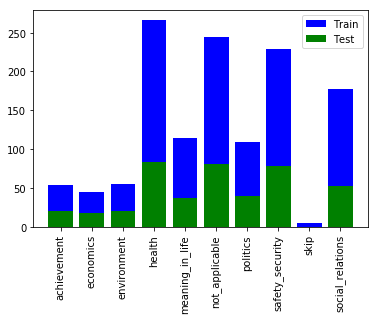

In [19]:
plt.bar(train_tags_counts.keys(), train_tags_counts.values(), color='b')
plt.bar(test_tags_counts.keys(), test_tags_counts.values(), color='g')
plt.xticks(rotation=90)
plt.legend(['Train', 'Test'])
plt.show()

In [20]:
def show_wordcloud(source, max_words=50):
    
    wordcloud = WordCloud(scale=4, max_words=1000)
    if type(source).__name__ == 'str' or type(source).__name__ == 'unicode':
        wordcloud.generate_from_text(source)
    else:
        wordcloud.generate_from_frequencies(source)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

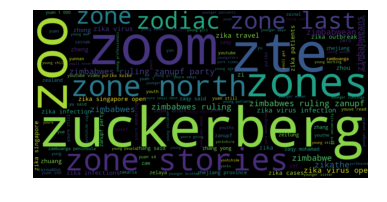

In [345]:
show_wordcloud(tfidf_vocab,1500)

In [346]:
sorted(tfidf_vocab.items(), key=lambda x:x[1], reverse=True)[:50]

[('zuckerberg', 42041),
 ('zte', 42040),
 ('zoom', 42039),
 ('zoo', 42038),
 ('zones', 42037),
 ('zone stories', 42036),
 ('zone north', 42035),
 ('zone last', 42034),
 ('zone', 42033),
 ('zodiac', 42032),
 ('zimbabwes ruling zanupf party', 42031),
 ('zimbabwes ruling zanupf', 42030),
 ('zimbabwes ruling', 42029),
 ('zimbabwes', 42028),
 ('zimbabweans', 42027),
 ('zimbabwean', 42026),
 ('zimbabwe', 42025),
 ('zikathe', 42024),
 ('zika virus open', 42023),
 ('zika virus infection', 42022),
 ('zika virus', 42021),
 ('zika travel', 42020),
 ('zika singapore open', 42019),
 ('zika singapore', 42018),
 ('zika patients', 42017),
 ('zika outbreak', 42016),
 ('zika infections', 42015),
 ('zika infection', 42014),
 ('zika cases', 42013),
 ('zika', 42012),
 ('zi', 42011),
 ('zhuang', 42010),
 ('zhou', 42009),
 ('zhong', 42008),
 ('zheng', 42007),
 ('zhejiang province', 42006),
 ('zhejiang', 42005),
 ('zhang yong', 42004),
 ('zhang said', 42003),
 ('zhang', 42002),
 ('zero', 42001),
 ('zelaya', 4

## Train:

In [2]:
mlb = MultiLabelBinarizer(classes=sorted(class_mapping.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

NameError: name 'MultiLabelBinarizer' is not defined

### LR

In [348]:
LR_classifier = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
accuracy_score(y_val, LR_classifier.fit(X_train_tfidf, y_train).predict(X_val_tfidf))

0.22507122507122507

### SVM:

In [349]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(X_train_tfidf, y_train).predict(X_val_tfidf)
accuracy_score(y_val, y_pred_svm)

0.4131054131054131

## Feature importance: (Using LR classifier)

In [398]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, number_of_words = 20):
    cof = classifier.estimators_[mlb.classes.index(tag)].coef_
    top_negative_words = {}
    top_positive_words = {}
    for k in np.argsort(-cof[0])[:number_of_words]:
        top_positive_words[tfidf_reversed_vocab[k]] = cof[0][k]
        
    for k in np.argsort(cof[0])[:number_of_words]:
        top_negative_words[tfidf_reversed_vocab[k]] = cof[0][k]
        
    print("Tag:\t" + str(class_mapping[tag]))
    print('positive words:\t{}'.format(', '.join(top_positive_words)))
    show_wordcloud(top_positive_words)
    print('negative words:\t{}\n'.format(', '.join(top_negative_words)))
    show_wordcloud(top_negative_words)

Tag:	achievement
positive words:	university, technology, cow, data, using, hair, helmet, robots, team, foreign domestic, designers, cancer, satellite, water, tumour, commuters, surgery, research, information, patients


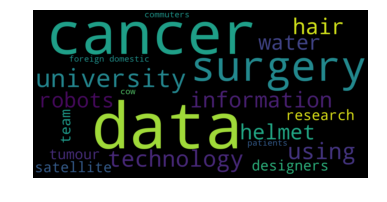

negative words:	mr, man, north korea, days, state, million, police, us, south, official, military, united, korean, korea, case, officials, chinese, trump, government, north



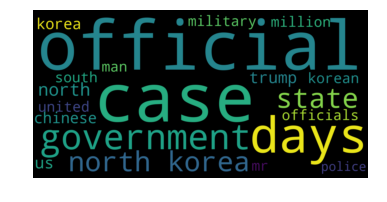

Tag:	economics
positive words:	economy, tax, retirement, cent, per cent, million, medifund, bitcoin, value, market, year, bank, per, markets, financial, billion, growth, investment, yuan, prices


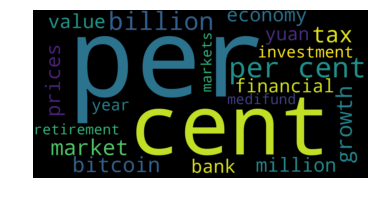

negative words:	people, told, man, hospital, family, study, camera, security, president, health, one, case, public, police, nuclear, apple, cancer, patients, found, north



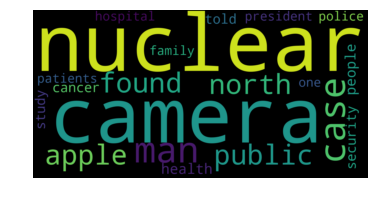

Tag:	politics
positive words:	mr, leader, former, trump, campaign, vote, mugabe, xi, resolution, senate, election, minister, parliament, russian, political, president, decision, party, trumps, government


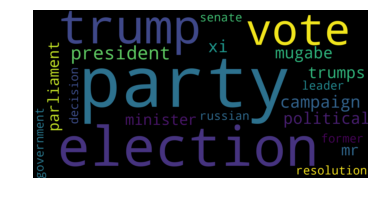

negative words:	per, man, camera, get, still, study, like, food, market, disease, cancer, dr, myanmar, one, blood, police, apple, mobile, company, found



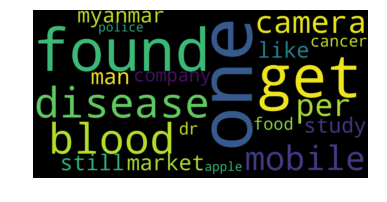

Tag:	not_applicable
positive words:	users, set, mobile, game, games, camera, new, market, music, galaxy, version, app, google, like, smartphone, apple, samsung, watch, tv, company


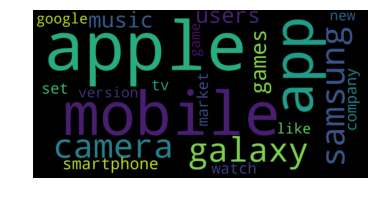

negative words:	people, virus, security, attack, police, government, cases, state, health, child, cancer, reuters, beijing, risk, korea, officials, medical, patients, said, north



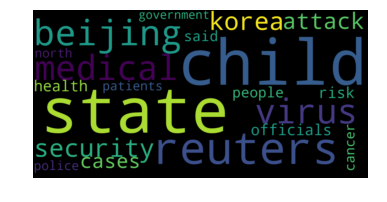

Tag:	skip
positive words:	professional, martial arts, martial, scramble, flyweight, orchard road, cbd, arts, crossing, career, battery, one championship, orchard, relegation, swatch, championship, clubs, shaw, sleague, watches


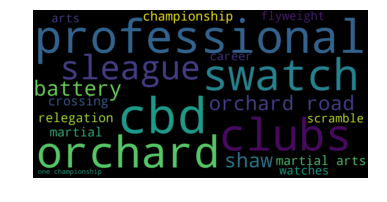

negative words:	people, security, cent, per cent, trump, police, said, health, president, two, years, per, us, time, chinese, patients, korea, first, china, north



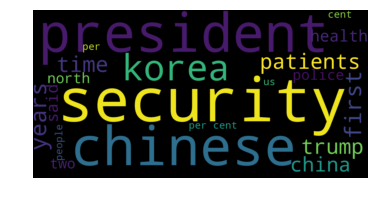

Tag:	health
positive words:	dengue, virus, smoking, may, study, zika, cases, food, health, disease, cancer, risk, hiv, blood, doctors, medical, symptoms, patients, treatment, drug


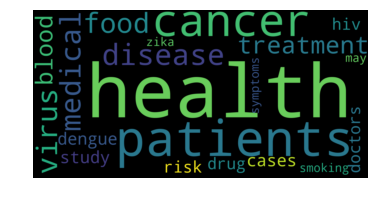

negative words:	mr, korea, camera, mobile, police, military, trump, government, security, president, online, app, chinese, us, party, north, customers, apple, jan, advertisement



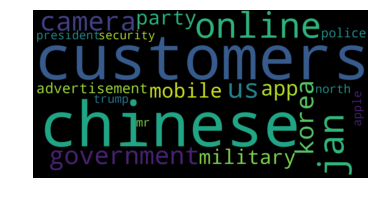

Tag:	safety_security
positive words:	police said, man, attacks, attack, syrian, incident, police, said, singpass, missile, security, killed, isis, victim, alert, victims, information, fire, suspect, north


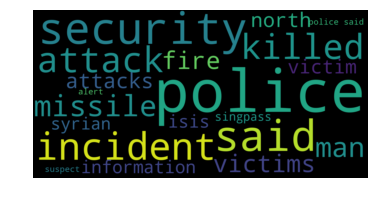

negative words:	mr, per cent, cent, trump, study, says, food, health, disease, per, million, new, chinese, hong, medical, apple, foreign, first, treatment, help



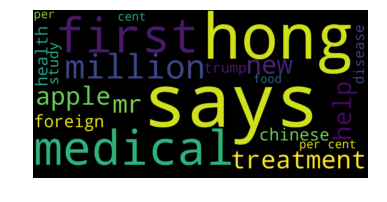

Tag:	environment
positive words:	emissions, pollution, fire, water, volcano, eruption, ash, air, environmental, climate, gas, climate change, floods, volcanic, plastic, mount, bags, winds, agung, greenpeace


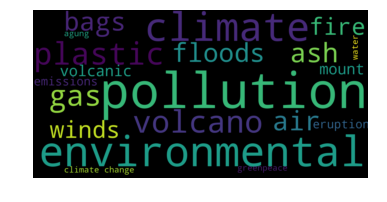

negative words:	women, man, cent, per cent, would, us, trump, dr, security, go, years, korean, korea, medical, chinese, new, apple, patients, party, virus



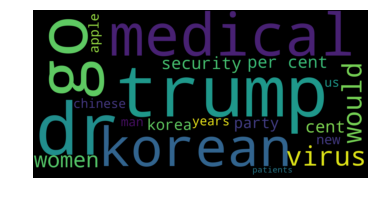

Tag:	social_relations
positive words:	military, eu, trump, missile, us, north korea, iran, war, president, security, minister, rohingya, korea, chinese, religious, united, myanmar, foreign, china, north


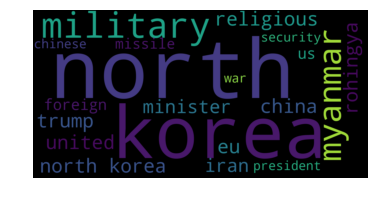

negative words:	hospital, data, per cent, cent, mobile, study, online, food, health, disease, cancer, per, app, service, medical, apple, patients, company, found, virus



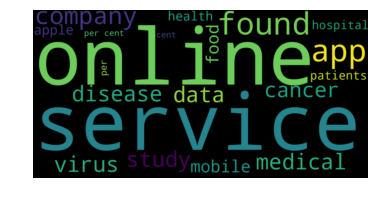

Tag:	meaning_in_life
positive words:	accused, court, man, woman, gay, women, police, said, bush, prison, girls, parents, sexual, arrested, girl, law, allegations, saipov, suspect, assault


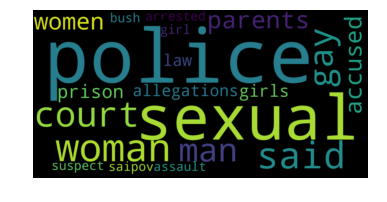

negative words:	university, mr, south, trump, need, study, north korea, health, disease, singapore, korea, get, chinese, hong, products, apple, data, patients, treatment, north



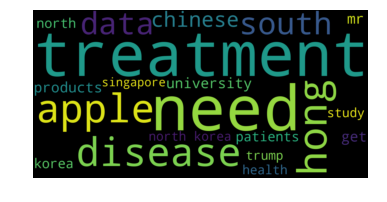

In [399]:
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
for key in class_mapping.keys():
    print_words_for_tag(LR_classifier, key, mlb.classes, tfidf_reversed_vocab)

### Classification report

In [373]:
from micromort.utils.classification_plotter import plot

/home/mannu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mannu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


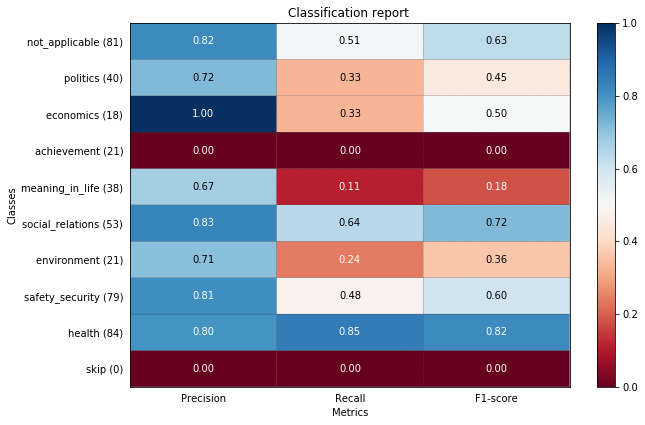

In [374]:
plot(sklearn.metrics.classification_report(y_val, y_pred_svm, target_names= [ 'skip',
'health','safety_security',  'environment', 'social_relations', 'meaning_in_life', 'achievement', 
'economics',  'politics', 'not_applicable']))

### Try with data = text + heading

In [464]:
train['full_text'] = train['article_headline'] + " " + train['article_text']
test['full_text'] =  test['article_headline'] + " " + test['article_text']

In [465]:
X_train, y_train = train['full_text'].values, train['risk_category'].values
X_val, y_val = test['full_text'].values, test['risk_category'].values

In [466]:
X_train = splitAndProcess(X_train, text_prepare, 8, 8)
X_val = splitAndProcess(X_val, text_prepare, 8, 8)

In [467]:
X_train_tfidf = tfidf_features(X_train)
X_val_tfidf = tfidf_features(X_val)

In [470]:
print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

number of features:  (1051, 42042) (351, 42042)


In [471]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(X_train_tfidf, y_train).predict(X_val_tfidf)
accuracy_score(y_val, y_pred_svm)

0.41595441595441596

Not of any help

In [34]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
# If you want to avoid the OneVsRestClassifier magic switch
# from sklearn.multioutput import MultiOutputClassifier

clf_multilabel = OneVsRestClassifier(XGBClassifier(), n_jobs=-1)

In [37]:
clf_multilabel.fit(X_train_tfidf, y_train)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f4f31b549b0>>
Traceback (most recent call last):
  File "/home/mannu/.local/lib/python3.5/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=-1)

In [38]:
y_val_predicted_labels_tfidf = clf_multilabel.predict(X_val_tfidf)
accuracy_score(y_val, y_val_predicted_labels_tfidf)

0.358974358974359

### Wory ebmeddings:

In [40]:
import numpy as np

with open("/home/mannu/data/wordEmbeddings/glove.6B.300d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

In [54]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.items())))


    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [55]:
ob = TfidfEmbeddingVectorizer(w2v)
ob.fit(X_train)

In [68]:
X_train_w2v = ob.transform(X_train)
X_val_w2v = ob.transform(X_val)

In [69]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(X_train_w2v, y_train).predict(X_val_w2v)
accuracy_score(y_val, y_pred_svm)

0.0

In [1]:
y_val

NameError: name 'y_val' is not defined